In [80]:
from sknetwork.clustering import Louvain, modularity, PropagationClustering, KMeans
from sknetwork.visualization import svg_graph, svg_digraph, svg_bigraph
from IPython.display import SVG
from sknetwork.embedding import GSVD
import networkx as nx
import geopandas as gpd
import matplotlib.pyplot as plt
from infomap import Infomap
import numpy as np
import itertools
import matplotlib as mpl
import pandas as pd
import time

### Infomap

In [2]:
def Create_Dictionary(G):
    #Diccionarios para recordar nombres
    dicId={}
    dicUbigeo={}
    n=0
    for i in G.nodes():
        dicId[n]=i
        dicUbigeo[i]=n
        n=n+1
    return dicId, dicUbigeo

In [3]:
def Read_Map(uMapLevel):
    fp = uMapLevel
    gdf = gpd.read_file(fp)
    gdf = gdf.set_geometry("geometry")
    gdf = gdf.to_crs("EPSG:4326")
    return gdf

In [163]:
def Infomap_function(G, minCodelength, minGrupos, minLabels, bipartite_teleportation, weight_threshold, two_level, teleportation_probability,
                     num_trials, core_loop_limit):
    
    im = Infomap()
    for e in G.edges.data("weight", default=1):
        im.addLink(dicUbigeo[e[0]],dicUbigeo[e[1]],e[2])

    # Run the Infomap search algorithm to find optimal modules
    im.run(bipartite_teleportation = bipartite_teleportation, weight_threshold = weight_threshold, 
           teleportation_probability = teleportation_probability, num_trials=num_trials,
           core_loop_limit =core_loop_limit,
           two_level=two_level, flow_model = 'directed')

    #print("Cantidad de grupos:",im.num_top_modules)
    np.zeros((2,3,4),dtype=np.int16)

    labels=np.zeros(G.number_of_nodes(),dtype=np.int16)

    for node in im.tree:
        if node.is_leaf:
            labels[node.node_id]=int(node.module_id)

    if ((im.codelength < minCodelength) | (minGrupos == 0)):
        minCodelength = im.codelength
        minGrupos = im.num_top_modules
        data=nx.adjacency_matrix(G)
        minLabels = labels
        
        #mod=modularity(data, labels)
    
    return minCodelength, minLabels, minGrupos

In [91]:
def Draw_Map(gdf, labels, level):
    # Asignar el grupo a cada elemento del geo-dataframe
    
    for i in range(len(labels)):
        if(level=="dep"):
            gdf.loc[gdf.IDDPTO==dicId[i],'GRUPO']=int(labels[i])
        elif(level=="pro"):
            gdf.loc[gdf.IDPROV==dicId[i],'GRUPO']=int(labels[i])
        elif(level=="dis"):
            gdf.loc[gdf.IDDIST==dicId[i],'GRUPO']=int(labels[i])
    # Pintar el Perú según los grupos
    plt.figure(3,figsize=(8,8)) 
    gdf.plot("GRUPO",legend=True)
    
    return gdf
    #gdf.loc[gdf.IDDPTO=='15'].plot("GRUPO",legend=True)
    #plt.savefig('Figuras/Louvain_{}_{}.png'.format(level,modularity_function))

In [167]:
def Draw_Groups(G,minLabels):
    cant_ele={}
    val_map={}
    no_graph=[]

    for i in range(len(minLabels)):
        #val_map[dicId[i]]=int(minLabels[i])
        if (not(minLabels[i] in cant_ele.keys())):
            cant_ele[minLabels[i]]=0
        cant_ele[minLabels[i]]+=1

    for i in cant_ele:
        if(cant_ele[i]>G.number_of_nodes()/2):
            no_graph.append(i)
            
    for i in range(len(minLabels)):
        if not(minLabels[i] in no_graph):
            val_map[dicId[i]]=int(minLabels[i])
        
    if(len(val_map)):
        G_subgroup = G.subgraph(val_map.keys())
        low, *_, high = sorted(val_map.values())
        norm = mpl.colors.Normalize(vmin=low, vmax=high, clip=True)
        mapper = mpl.cm.ScalarMappable(norm=norm, cmap=mpl.cm.coolwarm)
        values=[mapper.to_rgba(i) for i in val_map.values()]

        plt.figure(3,figsize=(15,15)) 
        nx.draw_circular(G_subgroup, cmap=plt.get_cmap('viridis'), node_color=values, with_labels=True, font_color='black',
                        font_size=10,node_size=1000)
        plt.show()
    else:
        print("No se generaron grupos válidos")
        
    return val_map

### Parámetros

In [158]:
bipartite_teleportation = [False]
weight_threshold = [150]
two_level = [False]
teleportation_probability = [0.75] 
num_trials = [9]
core_loop_limit = [10]
#False 150 False 0.75 9 10
options = [bipartite_teleportation, weight_threshold,two_level, teleportation_probability, num_trials, core_loop_limit]
params = list(itertools.product(*options))

### Departamentos

In [147]:
uGraph="Input/grafoPeruDepartamentos.net"
uMapLevel="Input/departamentos/DEPARTAMENTOS.shp"
level="dep"

grafo = nx.DiGraph(nx.read_pajek(uGraph))
dicId, dicUbigeo = Create_Dictionary(grafo)
gdf = Read_Map(uMapLevel)

minGrupos = minLabels = 0
minCodelength = 10000

for param in params:
    start_time = time.time()
    minCodelength, minLabels, minGrupos = Infomap_function(grafo, minCodelength, minGrupos, minLabels, *param)
    dep = [grafo.number_of_nodes(), grafo.number_of_edges(), time.time() - start_time]
    

Draw_Groups(grafo,minLabels)


No se generaron grupos válidos


### Provincias

In [146]:
uGraph="Input/grafoPeruProvincias.net"
uMapLevel="Input/provincias/PROVINCIAS.shp"
level="pro"
modularity_function='dugue'

grafo = nx.DiGraph(nx.read_pajek(uGraph))
dicId, dicUbigeo = Create_Dictionary(grafo)
gdf = Read_Map(uMapLevel)

minGrupos = minLabels = minParam = 0
minCodelength = 10000

for param in params:
    start_time = time.time()
    minCodelength, minLabels, minGrupos=Infomap_function(grafo, minCodelength, minGrupos, minLabels, *param)
    pro = [grafo.number_of_nodes(), grafo.number_of_edges(), time.time() - start_time]
    
Draw_Groups(grafo,minLabels)

No se generaron grupos válidos


### Distritos

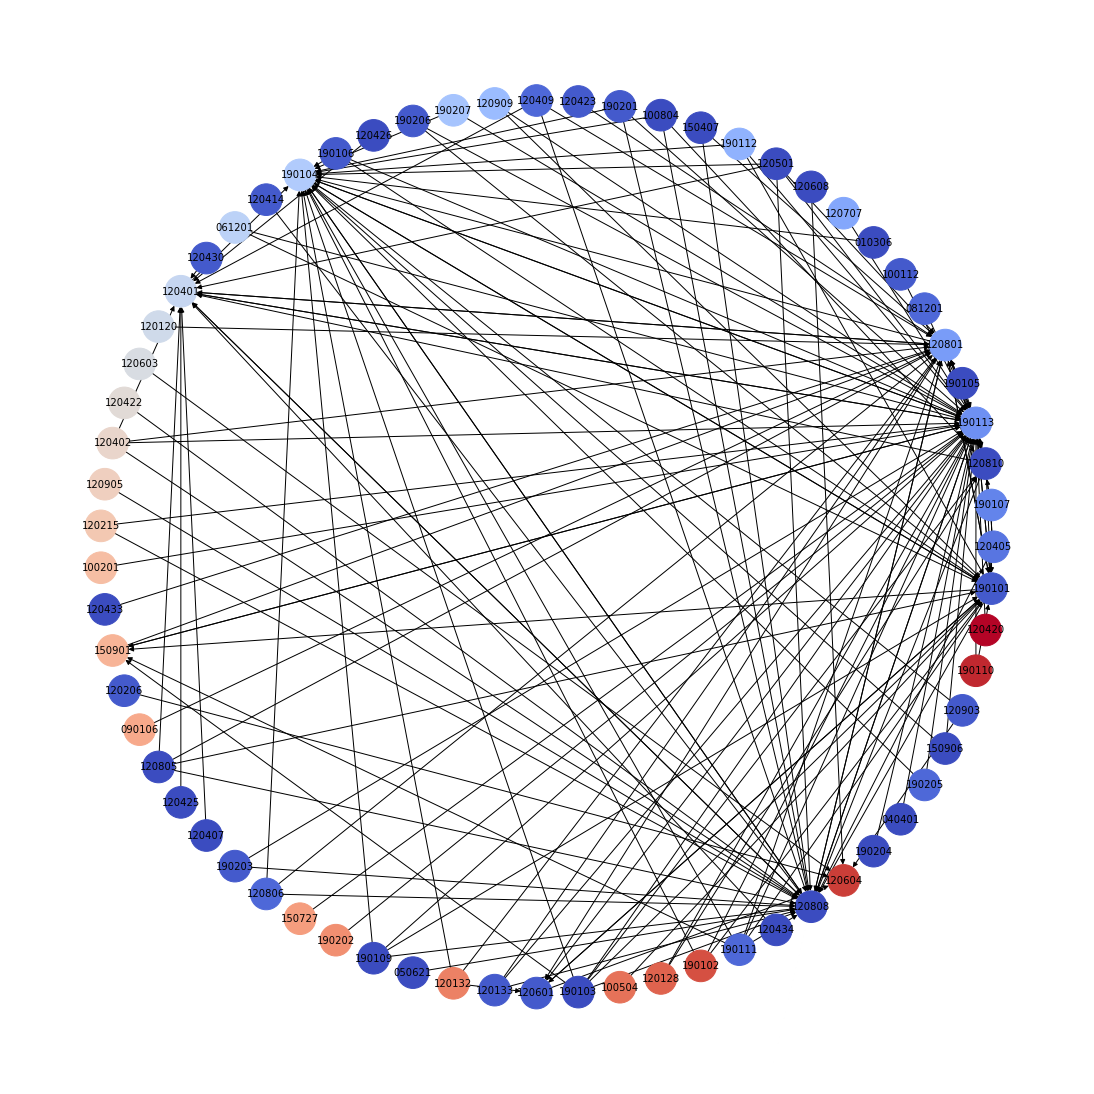

ValueError: If using all scalar values, you must pass an index

In [173]:
uGraph="Input/grafoPeruDistritos.net"
uMapLevel="Input/distritos/DISTRITOS.shp"
level="dis"
modularity_function='dugue'

grafo = nx.DiGraph(nx.read_pajek(uGraph))
dicId, dicUbigeo = Create_Dictionary(grafo)
gdf = Read_Map(uMapLevel)

minGrupos = minLabels = minParam = 0
minCodelength = 10000

param = params[0]
start_time = time.time()
minCodelength, minLabels, minGrupos=Infomap_function(grafo, minCodelength, minGrupos, minLabels, *param)
val_map = Draw_Groups(grafo,minLabels)
pd.DataFrame.from_dict(val_map)
dis = [grafo.number_of_nodes(), grafo.number_of_edges(), time.time() - start_time]
    


In [186]:
df = pd.DataFrame.from_dict(val_map, orient='index')

In [187]:
df.to_csv('out.csv', index=True)  

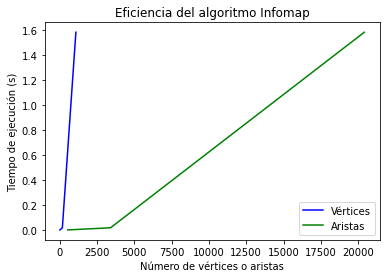

In [180]:
lst = [dep, pro, dis]

df = pd.DataFrame(lst, columns =['nVertex', 'nEdges', 'RT'])
runtime = df['RT']
nVertex = df['nVertex'] 
nEdges = df['nEdges'] 

plt.plot(nVertex, runtime, 'b-', label='Vértices')
plt.plot(nEdges, runtime, 'g-', label='Aristas')
plt.legend(loc='lower right')
plt.title("Eficiencia del algoritmo Infomap")
plt.xlabel('Número de vértices o aristas')
plt.ylabel('Tiempo de ejecución (s)')
plt.savefig('Figuras/eficiencia_A2.png')

In [181]:
df

,nVertex,nEdges,RT
0,25,549,0.001998
1,189,3417,0.019003
2,1094,20403,1.581959
